In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, concatenate

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1, 7"

### Dataset

In [3]:
dataset = pd.read_csv('../../data/TFT_energy.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [4]:
# # Plot Pearson correlation matrix
# import seaborn as sns

# correlations = data.corr(method='pearson')
# fig = plt.figure(figsize=(24, 24))
# sns.heatmap(correlations, annot=True, fmt='.2f')
# plt.title('Pearson Correlation Matrix')
# plt.show()

In [5]:
# data.tail(10)

### Dataset Information

In [6]:
print(list(data.columns))

['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual', 'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona', 'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia', 'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville', 'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river', 'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia', 'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']


### Pre-processing

In [7]:
# specify the number of lag hours
n_hours = 24*3
K = 24
n_features = data.shape[1]

#### Stage

In [8]:
# Pre-processing
# Stage --> 8 stages
pms = dataset[['price']]
print("pms.shape:", pms.shape)

# stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
pms_supervised = series_to_supervised(pms, n_hours, K)
pms_supervised.reset_index(drop=True, inplace=True)
print("pms_supervised.shape:", pms_supervised.shape)

pms.shape: (35063, 1)
pms_supervised.shape: (34968, 96)


In [9]:
# pms_supervised

#### Prior known covariates (9)

In [10]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
prior_known_cov = data[['price_dayahead','gen_coal', 'gen_gas', 'load_actual', 'gen_lig', 'gen_oil', \
                        'gen_oth_renew', 'pressure_Barcelona', 'pressure_Bilbao', \
                        'gen_waste', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]
print("prior_known_cov.shape:", prior_known_cov.shape)

prior_known_cov_supervised = series_to_supervised(prior_known_cov, n_hours, K)
print("prior_known_cov_supervised.shape:", prior_known_cov_supervised.shape)

prior_known_cov.shape: (35063, 13)
prior_known_cov_supervised.shape: (34968, 1248)


In [11]:
prior_known_cov_supervised.reset_index(drop=True, inplace=True)
prior_known_cov_supervised.columns = ['past_known_cov_' + i for i in list(prior_known_cov_supervised.columns)]

In [12]:
prior_known_cov_supervised

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23),past_known_cov_var11(t+23),past_known_cov_var12(t+23),past_known_cov_var13(t+23)
0,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,195.0,...,25069.0,326.0,352.0,72.0,1030.0,1033.0,158.0,7351.0,1.0,650.0
1,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,196.0,...,23390.0,104.0,310.0,74.0,1027.0,1032.0,153.0,7403.0,1.0,938.0
2,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,191.0,...,21988.0,0.0,311.0,75.0,1027.0,1032.0,156.0,7887.0,1.0,1021.0
3,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,189.0,...,21182.0,0.0,308.0,71.0,1027.0,1031.0,155.0,8348.0,1.0,2067.0
4,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,188.0,...,20778.0,0.0,308.0,71.0,1026.0,1031.0,155.0,8348.0,1.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,70.00,2923.0,13280.0,33142.0,721.0,308.0,95.0,1027.0,1028.0,307.0,...,30653.0,0.0,178.0,95.0,1027.0,1033.0,277.0,3113.0,1.0,1.0
34964,70.01,2932.0,13091.0,32669.0,721.0,308.0,98.0,1027.0,1028.0,306.0,...,29735.0,0.0,174.0,95.0,1027.0,1034.0,280.0,3288.0,1.0,1.0
34965,68.71,2941.0,11128.0,30753.0,721.0,307.0,95.0,1027.0,1029.0,304.0,...,28071.0,0.0,168.0,94.0,1028.0,1034.0,286.0,3503.0,1.0,50.0
34966,68.40,2921.0,9240.0,27882.0,705.0,306.0,96.0,1027.0,1029.0,308.0,...,25801.0,0.0,163.0,93.0,1028.0,1034.0,287.0,3586.0,2.0,108.0


In [13]:
prior_known_future_cov = prior_known_cov_supervised.iloc[:, n_hours*prior_known_cov.shape[1]:]
prior_known_future_cov

,past_known_cov_var1(t),past_known_cov_var2(t),past_known_cov_var3(t),past_known_cov_var4(t),past_known_cov_var5(t),past_known_cov_var6(t),past_known_cov_var7(t),past_known_cov_var8(t),past_known_cov_var9(t),past_known_cov_var10(t),...,past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23),past_known_cov_var11(t+23),past_known_cov_var12(t+23),past_known_cov_var13(t+23)
0,20.20,2755.0,3997.0,23620.0,0.0,310.0,58.0,1027.0,1037.0,160.0,...,25069.0,326.0,352.0,72.0,1030.0,1033.0,158.0,7351.0,1.0,650.0
1,19.16,2678.0,3787.0,22606.0,0.0,306.0,57.0,1027.0,1037.0,161.0,...,23390.0,104.0,310.0,74.0,1027.0,1032.0,153.0,7403.0,1.0,938.0
2,21.90,2426.0,3724.0,22191.0,0.0,311.0,56.0,1028.0,1036.0,162.0,...,21988.0,0.0,311.0,75.0,1027.0,1032.0,156.0,7887.0,1.0,1021.0
3,14.90,2046.0,3578.0,21929.0,0.0,310.0,56.0,1027.0,1036.0,161.0,...,21182.0,0.0,308.0,71.0,1027.0,1031.0,155.0,8348.0,1.0,2067.0
4,24.65,2248.0,3676.0,22195.0,0.0,310.0,58.0,1027.0,1036.0,157.0,...,20778.0,0.0,308.0,71.0,1026.0,1031.0,155.0,8348.0,1.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,67.83,1556.0,5683.0,30042.0,0.0,221.0,97.0,1027.0,1034.0,311.0,...,30653.0,0.0,178.0,95.0,1027.0,1033.0,277.0,3113.0,1.0,1.0
34964,68.40,1616.0,5859.0,30229.0,0.0,216.0,96.0,1027.0,1035.0,314.0,...,29735.0,0.0,174.0,95.0,1027.0,1034.0,280.0,3288.0,1.0,1.0
34965,67.64,1610.0,5660.0,29145.0,0.0,215.0,98.0,1028.0,1035.0,316.0,...,28071.0,0.0,168.0,94.0,1028.0,1034.0,286.0,3503.0,1.0,50.0
34966,65.27,1622.0,5603.0,26934.0,0.0,225.0,98.0,1028.0,1035.0,309.0,...,25801.0,0.0,163.0,93.0,1028.0,1034.0,287.0,3586.0,2.0,108.0


In [14]:
prior_known_future_cov.shape

(34968, 312)

### N_out, N_in, K

In [15]:
# specify the number of lag hours
n_features = pms.shape[1] + prior_known_cov.shape[1]
n_features

14

### Concatenation

In [16]:
past_prior_known_cov_supervised = prior_known_cov_supervised.iloc[:, :n_hours*prior_known_cov.shape[1]]

In [17]:
columns = []
for i in range(n_hours):
    #columns = columns + past_prior_unknown_cov_supervised.columns[i*prior_unknown_cov.shape[1]:(i+1)*prior_unknown_cov.shape[1]].tolist()
    columns = columns + past_prior_known_cov_supervised.columns[i*prior_known_cov.shape[1]:(i+1)*prior_known_cov.shape[1]].tolist()
# columns

In [18]:
past_unknown_known_cov = concat([
                                #past_prior_unknown_cov_supervised, 
                                past_prior_known_cov_supervised],
                                axis=1)

In [19]:
past_unknown_known_cov

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var4(t-1),past_known_cov_var5(t-1),past_known_cov_var6(t-1),past_known_cov_var7(t-1),past_known_cov_var8(t-1),past_known_cov_var9(t-1),past_known_cov_var10(t-1),past_known_cov_var11(t-1),past_known_cov_var12(t-1),past_known_cov_var13(t-1)
0,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,195.0,...,25254.0,0.0,323.0,58.0,1028.0,1037.0,162.0,8540.0,0.0,1045.0
1,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,196.0,...,23620.0,0.0,310.0,58.0,1027.0,1037.0,160.0,8080.0,0.0,1257.0
2,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,191.0,...,22606.0,0.0,306.0,57.0,1027.0,1037.0,161.0,7773.0,1.0,1629.0
3,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,189.0,...,22191.0,0.0,311.0,56.0,1028.0,1036.0,162.0,7601.0,1.0,1962.0
4,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,188.0,...,21929.0,0.0,310.0,56.0,1027.0,1036.0,161.0,7584.0,1.0,2185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,70.00,2923.0,13280.0,33142.0,721.0,308.0,95.0,1027.0,1028.0,307.0,...,29221.0,0.0,228.0,96.0,1027.0,1034.0,311.0,5129.0,1.0,1.0
34964,70.01,2932.0,13091.0,32669.0,721.0,308.0,98.0,1027.0,1028.0,306.0,...,30042.0,0.0,221.0,97.0,1027.0,1034.0,311.0,5406.0,1.0,1.0
34965,68.71,2941.0,11128.0,30753.0,721.0,307.0,95.0,1027.0,1029.0,304.0,...,30229.0,0.0,216.0,96.0,1027.0,1035.0,314.0,5193.0,0.0,1.0
34966,68.40,2921.0,9240.0,27882.0,705.0,306.0,96.0,1027.0,1029.0,308.0,...,29145.0,0.0,215.0,98.0,1028.0,1035.0,316.0,4912.0,1.0,1.0


In [20]:
# non_stages_supervised.reset_index(drop=True, inplace=True)
# stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([past_unknown_known_cov, pms_supervised.iloc[:, :]], axis=1)

In [21]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (34968, 1032)


In [22]:
# all_data

### Train & Test set

In [23]:
all_data = all_data.values
future_covariates = prior_known_future_cov.values

In [24]:
n_train_hours = int(len(data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 28050


In [25]:
train_future_cov = prior_known_future_cov.iloc[:n_train_hours, :]
test_future_cov = prior_known_future_cov.iloc[n_train_hours:, :] 

In [26]:
test_future_cov.shape

(6918, 312)

### Normalization

In [27]:
n_hours

72

In [28]:
n_features

14

In [29]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (28050, 1008) (28050, 24) (6918, 1008) (6918, 24)


In [30]:
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))

train_future_cov = scaler1.fit_transform(train_future_cov)
test_future_cov = scaler1.fit_transform(test_future_cov)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (28050, 312) (6918, 312)


In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (28050, 72, 14) (28050, 24) (6918, 72, 14) (6918, 24)


In [32]:
train_future_cov = train_future_cov.reshape(train_future_cov.shape[0], K, -1)
test_future_cov = test_future_cov.reshape(test_future_cov.shape[0], K, -1)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (28050, 24, 13) (6918, 24, 13)


In [33]:
# train_y = train_y.reshape((train_y.shape[0], K, -1))
# test_y = test_y.reshape((test_y.shape[0], K, -1))
# print(train_y.shape, test_y.shape)

In [34]:
# past_inputs

### Model

In [34]:
# Encoding the past
past_inputs = tf.keras.Input(shape=(n_hours, n_features), name='past_inputs')
encoder = tf.keras.layers.Conv1D(filters=256, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_inputs)
encoder = tf.keras.layers.Conv1D(filters=128, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.Conv1D(filters=64, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.Conv1D(filters=13, 
                                 kernel_size=2, 
                                 activation='relu', 
                                 padding='same', 
                                 kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)


# Combine past + future
future_inputs = tf.keras.Input(shape=(K, prior_known_cov.shape[1]), name='future_inputs')

past_future_input = concatenate([encoder, future_inputs], axis=1)


# decoder
decoder = tf.keras.layers.Conv1D(filters=128, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_future_input)
decoder = tf.keras.layers.Conv1D(filters=64, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.Conv1D(filters=32, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.Conv1D(filters=16, 
                                  kernel_size=2, 
                                  activation='relu', 
                                  padding='same', 
                                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)

fc = layers.Flatten()(decoder)

# final output
fc = tf.keras.layers.Dense(256, activation='relu')(fc)
fc = tf.keras.layers.Dense(128, activation='relu')(fc)
fc = tf.keras.layers.Dense(64, activation='relu')(fc)
output = tf.keras.layers.Dense(train_y.shape[1])(fc)

model = tf.keras.models.Model(inputs=[past_inputs, future_inputs], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, 72, 14)]     0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 72, 256)      7424        past_inputs[0][0]                
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 72, 128)      65664       conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 72, 64)       16448       conv1d_9[0][0]                   
____________________________________________________________________________________________

Epoch 1/6000


2023-02-05 15:00:19.038187: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-05 15:00:19.628346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-05 15:00:24.016945: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-02-05 15:00:24.152999: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.19986, saving model to saved_model/cnn_encoder_decoder_24h_energy.h5
55/55 - 42s - loss: 0.0939 - mae: 0.1325 - val_loss: 0.1002 - val_mae: 0.1999
Epoch 2/6000

Epoch 00002: val_mae improved from 0.19986 to 0.08266, saving model to saved_model/cnn_encoder_decoder_24h_energy.h5
55/55 - 1s - loss: 0.0541 - mae: 0.0766 - val_loss: 0.0485 - val_mae: 0.0827
Epoch 3/6000

Epoch 00003: val_mae improved from 0.08266 to 0.06395, saving model to saved_model/cnn_encoder_decoder_24h_energy.h5
55/55 - 1s - loss: 0.0394 - mae: 0.0584 - val_loss: 0.0361 - val_mae: 0.0639
Epoch 4/6000

Epoch 00004: val_mae improved from 0.06395 to 0.05343, saving model to saved_model/cnn_encoder_decoder_24h_energy.h5
55/55 - 1s - loss: 0.0315 - mae: 0.0521 - val_loss: 0.0295 - val_mae: 0.0534
Epoch 5/6000

Epoch 00005: val_mae improved from 0.05343 to 0.05176, saving model to saved_model/cnn_encoder_decoder_24h_energy.h5
55/55 - 1s - loss: 0.0271 - mae: 0.0488 - val_loss: 0

Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.04499
55/55 - 1s - loss: 0.0064 - mae: 0.0372 - val_loss: 0.0076 - val_mae: 0.0454
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.04499
55/55 - 1s - loss: 0.0063 - mae: 0.0364 - val_loss: 0.0075 - val_mae: 0.0454
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.04499
55/55 - 1s - loss: 0.0062 - mae: 0.0361 - val_loss: 0.0081 - val_mae: 0.0510
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.04499
55/55 - 1s - loss: 0.0061 - mae: 0.0363 - val_loss: 0.0076 - val_mae: 0.0477
Epoch 58/6000

Epoch 00058: val_mae did not improve from 0.04499
55/55 - 1s - loss: 0.0060 - mae: 0.0359 - val_loss: 0.0077 - val_mae: 0.0489
Epoch 59/6000

Epoch 00059: val_mae did not improve from 0.04499
55/55 - 1s - loss: 0.0060 - mae: 0.0363 - val_loss: 0.0074 - val_mae: 0.0463
Epoch 60/6000

Epoch 00060: val_mae did not improve from 0.04499
55/55 - 1s - loss: 0.0059 - mae: 0.0357 - val_loss: 0.0072 - val_mae: 0.0451
Epoch 

Epoch 109/6000

Epoch 00109: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0039 - mae: 0.0328 - val_loss: 0.0056 - val_mae: 0.0450
Epoch 110/6000

Epoch 00110: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0039 - mae: 0.0332 - val_loss: 0.0054 - val_mae: 0.0440
Epoch 111/6000

Epoch 00111: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0039 - mae: 0.0328 - val_loss: 0.0057 - val_mae: 0.0466
Epoch 112/6000

Epoch 00112: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0039 - mae: 0.0331 - val_loss: 0.0054 - val_mae: 0.0441
Epoch 113/6000

Epoch 00113: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0039 - mae: 0.0331 - val_loss: 0.0060 - val_mae: 0.0496
Epoch 114/6000

Epoch 00114: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0038 - mae: 0.0326 - val_loss: 0.0055 - val_mae: 0.0446
Epoch 115/6000

Epoch 00115: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0038 - mae: 0.0326 - val_loss: 0.0055 - val_mae: 0.0450

Epoch 167/6000

Epoch 00167: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0030 - mae: 0.0309 - val_loss: 0.0049 - val_mae: 0.0446
Epoch 168/6000

Epoch 00168: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0030 - mae: 0.0305 - val_loss: 0.0053 - val_mae: 0.0469
Epoch 169/6000

Epoch 00169: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0031 - mae: 0.0317 - val_loss: 0.0050 - val_mae: 0.0454
Epoch 170/6000

Epoch 00170: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0029 - mae: 0.0304 - val_loss: 0.0052 - val_mae: 0.0469
Epoch 171/6000

Epoch 00171: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0029 - mae: 0.0305 - val_loss: 0.0052 - val_mae: 0.0464
Epoch 172/6000

Epoch 00172: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0030 - mae: 0.0308 - val_loss: 0.0051 - val_mae: 0.0460
Epoch 173/6000

Epoch 00173: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0029 - mae: 0.0306 - val_loss: 0.0049 - val_mae: 0.0447

Epoch 225/6000

Epoch 00225: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0024 - mae: 0.0285 - val_loss: 0.0055 - val_mae: 0.0497
Epoch 226/6000

Epoch 00226: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0025 - mae: 0.0287 - val_loss: 0.0069 - val_mae: 0.0580
Epoch 227/6000

Epoch 00227: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0024 - mae: 0.0285 - val_loss: 0.0053 - val_mae: 0.0485
Epoch 228/6000

Epoch 00228: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0024 - mae: 0.0285 - val_loss: 0.0050 - val_mae: 0.0469
Epoch 229/6000

Epoch 00229: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0024 - mae: 0.0287 - val_loss: 0.0055 - val_mae: 0.0501
Epoch 230/6000

Epoch 00230: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0025 - mae: 0.0289 - val_loss: 0.0054 - val_mae: 0.0485
Epoch 231/6000

Epoch 00231: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0024 - mae: 0.0288 - val_loss: 0.0050 - val_mae: 0.0462

Epoch 283/6000

Epoch 00283: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0021 - mae: 0.0266 - val_loss: 0.0053 - val_mae: 0.0482
Epoch 284/6000

Epoch 00284: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0021 - mae: 0.0268 - val_loss: 0.0061 - val_mae: 0.0531
Epoch 285/6000

Epoch 00285: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0021 - mae: 0.0269 - val_loss: 0.0061 - val_mae: 0.0539
Epoch 286/6000

Epoch 00286: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0021 - mae: 0.0267 - val_loss: 0.0048 - val_mae: 0.0452
Epoch 287/6000

Epoch 00287: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0022 - mae: 0.0279 - val_loss: 0.0069 - val_mae: 0.0579
Epoch 288/6000

Epoch 00288: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0021 - mae: 0.0267 - val_loss: 0.0055 - val_mae: 0.0501
Epoch 289/6000

Epoch 00289: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0021 - mae: 0.0272 - val_loss: 0.0057 - val_mae: 0.0511

Epoch 341/6000

Epoch 00341: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0018 - mae: 0.0252 - val_loss: 0.0055 - val_mae: 0.0495
Epoch 342/6000

Epoch 00342: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0019 - mae: 0.0253 - val_loss: 0.0056 - val_mae: 0.0501
Epoch 343/6000

Epoch 00343: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0018 - mae: 0.0252 - val_loss: 0.0050 - val_mae: 0.0473
Epoch 344/6000

Epoch 00344: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0019 - mae: 0.0257 - val_loss: 0.0059 - val_mae: 0.0524
Epoch 345/6000

Epoch 00345: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0018 - mae: 0.0250 - val_loss: 0.0054 - val_mae: 0.0489
Epoch 346/6000

Epoch 00346: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0018 - mae: 0.0249 - val_loss: 0.0064 - val_mae: 0.0560
Epoch 347/6000

Epoch 00347: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0019 - mae: 0.0254 - val_loss: 0.0057 - val_mae: 0.0513

Epoch 399/6000

Epoch 00399: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0017 - mae: 0.0242 - val_loss: 0.0059 - val_mae: 0.0527
Epoch 400/6000

Epoch 00400: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0017 - mae: 0.0239 - val_loss: 0.0060 - val_mae: 0.0531
Epoch 401/6000

Epoch 00401: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0017 - mae: 0.0241 - val_loss: 0.0065 - val_mae: 0.0551
Epoch 402/6000

Epoch 00402: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0017 - mae: 0.0242 - val_loss: 0.0060 - val_mae: 0.0532
Epoch 403/6000

Epoch 00403: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0017 - mae: 0.0241 - val_loss: 0.0056 - val_mae: 0.0507
Epoch 404/6000

Epoch 00404: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0017 - mae: 0.0240 - val_loss: 0.0058 - val_mae: 0.0527
Epoch 405/6000

Epoch 00405: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0017 - mae: 0.0240 - val_loss: 0.0054 - val_mae: 0.0489

Epoch 457/6000

Epoch 00457: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0015 - mae: 0.0230 - val_loss: 0.0071 - val_mae: 0.0590
Epoch 458/6000

Epoch 00458: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0015 - mae: 0.0232 - val_loss: 0.0059 - val_mae: 0.0525
Epoch 459/6000

Epoch 00459: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0015 - mae: 0.0230 - val_loss: 0.0059 - val_mae: 0.0525
Epoch 460/6000

Epoch 00460: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0016 - mae: 0.0236 - val_loss: 0.0067 - val_mae: 0.0572
Epoch 461/6000

Epoch 00461: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0015 - mae: 0.0232 - val_loss: 0.0058 - val_mae: 0.0511
Epoch 462/6000

Epoch 00462: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0015 - mae: 0.0231 - val_loss: 0.0059 - val_mae: 0.0529
Epoch 463/6000

Epoch 00463: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0015 - mae: 0.0230 - val_loss: 0.0062 - val_mae: 0.0533

Epoch 515/6000

Epoch 00515: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0014 - mae: 0.0223 - val_loss: 0.0063 - val_mae: 0.0543
Epoch 516/6000

Epoch 00516: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0015 - mae: 0.0225 - val_loss: 0.0063 - val_mae: 0.0543
Epoch 517/6000

Epoch 00517: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0014 - mae: 0.0223 - val_loss: 0.0062 - val_mae: 0.0533
Epoch 518/6000

Epoch 00518: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0015 - mae: 0.0226 - val_loss: 0.0060 - val_mae: 0.0533
Epoch 519/6000

Epoch 00519: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0014 - mae: 0.0224 - val_loss: 0.0066 - val_mae: 0.0565
Epoch 520/6000

Epoch 00520: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0014 - mae: 0.0226 - val_loss: 0.0065 - val_mae: 0.0557
Epoch 521/6000

Epoch 00521: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0014 - mae: 0.0223 - val_loss: 0.0067 - val_mae: 0.0573

Epoch 573/6000

Epoch 00573: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0014 - mae: 0.0218 - val_loss: 0.0069 - val_mae: 0.0584
Epoch 574/6000

Epoch 00574: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0216 - val_loss: 0.0067 - val_mae: 0.0563
Epoch 575/6000

Epoch 00575: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0216 - val_loss: 0.0064 - val_mae: 0.0551
Epoch 576/6000

Epoch 00576: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0215 - val_loss: 0.0068 - val_mae: 0.0572
Epoch 577/6000

Epoch 00577: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0014 - mae: 0.0221 - val_loss: 0.0065 - val_mae: 0.0552
Epoch 578/6000

Epoch 00578: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0014 - mae: 0.0223 - val_loss: 0.0070 - val_mae: 0.0595
Epoch 579/6000

Epoch 00579: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0014 - mae: 0.0219 - val_loss: 0.0068 - val_mae: 0.0573

Epoch 631/6000

Epoch 00631: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0214 - val_loss: 0.0073 - val_mae: 0.0608
Epoch 632/6000

Epoch 00632: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0211 - val_loss: 0.0066 - val_mae: 0.0560
Epoch 633/6000

Epoch 00633: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0213 - val_loss: 0.0064 - val_mae: 0.0554
Epoch 634/6000

Epoch 00634: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0212 - val_loss: 0.0067 - val_mae: 0.0567
Epoch 635/6000

Epoch 00635: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0215 - val_loss: 0.0068 - val_mae: 0.0586
Epoch 636/6000

Epoch 00636: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0213 - val_loss: 0.0071 - val_mae: 0.0597
Epoch 637/6000

Epoch 00637: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0013 - mae: 0.0212 - val_loss: 0.0065 - val_mae: 0.0563

Epoch 689/6000

Epoch 00689: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0206 - val_loss: 0.0064 - val_mae: 0.0552
Epoch 690/6000

Epoch 00690: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0206 - val_loss: 0.0072 - val_mae: 0.0601
Epoch 691/6000

Epoch 00691: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0208 - val_loss: 0.0073 - val_mae: 0.0603
Epoch 692/6000

Epoch 00692: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0208 - val_loss: 0.0077 - val_mae: 0.0630
Epoch 693/6000

Epoch 00693: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0207 - val_loss: 0.0070 - val_mae: 0.0598
Epoch 694/6000

Epoch 00694: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0205 - val_loss: 0.0071 - val_mae: 0.0594
Epoch 695/6000

Epoch 00695: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0206 - val_loss: 0.0070 - val_mae: 0.0596

Epoch 747/6000

Epoch 00747: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0205 - val_loss: 0.0069 - val_mae: 0.0577
Epoch 748/6000

Epoch 00748: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0202 - val_loss: 0.0070 - val_mae: 0.0598
Epoch 749/6000

Epoch 00749: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0203 - val_loss: 0.0068 - val_mae: 0.0578
Epoch 750/6000

Epoch 00750: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0203 - val_loss: 0.0073 - val_mae: 0.0606
Epoch 751/6000

Epoch 00751: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0204 - val_loss: 0.0077 - val_mae: 0.0635
Epoch 752/6000

Epoch 00752: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0204 - val_loss: 0.0066 - val_mae: 0.0556
Epoch 753/6000

Epoch 00753: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0203 - val_loss: 0.0067 - val_mae: 0.0574

Epoch 805/6000

Epoch 00805: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0072 - val_mae: 0.0599
Epoch 806/6000

Epoch 00806: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0200 - val_loss: 0.0073 - val_mae: 0.0609
Epoch 807/6000

Epoch 00807: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0077 - val_mae: 0.0631
Epoch 808/6000

Epoch 00808: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0073 - val_mae: 0.0605
Epoch 809/6000

Epoch 00809: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0075 - val_mae: 0.0620
Epoch 810/6000

Epoch 00810: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0068 - val_mae: 0.0580
Epoch 811/6000

Epoch 00811: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0012 - mae: 0.0208 - val_loss: 0.0071 - val_mae: 0.0582

Epoch 863/6000

Epoch 00863: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0200 - val_loss: 0.0076 - val_mae: 0.0616
Epoch 864/6000

Epoch 00864: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0196 - val_loss: 0.0078 - val_mae: 0.0636
Epoch 865/6000

Epoch 00865: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0074 - val_mae: 0.0612
Epoch 866/6000

Epoch 00866: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0080 - val_mae: 0.0646
Epoch 867/6000

Epoch 00867: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0197 - val_loss: 0.0072 - val_mae: 0.0597
Epoch 868/6000

Epoch 00868: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0197 - val_loss: 0.0072 - val_mae: 0.0598
Epoch 869/6000

Epoch 00869: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0198 - val_loss: 0.0073 - val_mae: 0.0603

Epoch 921/6000

Epoch 00921: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0194 - val_loss: 0.0077 - val_mae: 0.0624
Epoch 922/6000

Epoch 00922: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0194 - val_loss: 0.0087 - val_mae: 0.0676
Epoch 923/6000

Epoch 00923: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0193 - val_loss: 0.0082 - val_mae: 0.0654
Epoch 924/6000

Epoch 00924: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0193 - val_loss: 0.0078 - val_mae: 0.0630
Epoch 925/6000

Epoch 00925: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0194 - val_loss: 0.0079 - val_mae: 0.0639
Epoch 926/6000

Epoch 00926: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0195 - val_loss: 0.0081 - val_mae: 0.0647
Epoch 927/6000

Epoch 00927: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0196 - val_loss: 0.0075 - val_mae: 0.0610

Epoch 979/6000

Epoch 00979: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0191 - val_loss: 0.0079 - val_mae: 0.0622
Epoch 980/6000

Epoch 00980: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0192 - val_loss: 0.0074 - val_mae: 0.0598
Epoch 981/6000

Epoch 00981: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0193 - val_loss: 0.0072 - val_mae: 0.0598
Epoch 982/6000

Epoch 00982: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0189 - val_loss: 0.0083 - val_mae: 0.0661
Epoch 983/6000

Epoch 00983: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0189 - val_loss: 0.0082 - val_mae: 0.0654
Epoch 984/6000

Epoch 00984: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0011 - mae: 0.0193 - val_loss: 0.0079 - val_mae: 0.0637
Epoch 985/6000

Epoch 00985: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0189 - val_loss: 0.0073 - val_mae: 0.0599


Epoch 01036: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0075 - val_mae: 0.0610
Epoch 1037/6000

Epoch 01037: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0189 - val_loss: 0.0079 - val_mae: 0.0635
Epoch 1038/6000

Epoch 01038: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0081 - val_mae: 0.0644
Epoch 1039/6000

Epoch 01039: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0079 - val_mae: 0.0634
Epoch 1040/6000

Epoch 01040: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0081 - val_mae: 0.0651
Epoch 1041/6000

Epoch 01041: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0189 - val_loss: 0.0079 - val_mae: 0.0638
Epoch 1042/6000

Epoch 01042: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0081 - val_mae: 0.0648
Epoch 10

Epoch 1093/6000

Epoch 01093: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.9489e-04 - mae: 0.0186 - val_loss: 0.0079 - val_mae: 0.0632
Epoch 1094/6000

Epoch 01094: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.9166e-04 - mae: 0.0185 - val_loss: 0.0087 - val_mae: 0.0675
Epoch 1095/6000

Epoch 01095: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0187 - val_loss: 0.0086 - val_mae: 0.0664
Epoch 1096/6000

Epoch 01096: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0088 - val_mae: 0.0678
Epoch 1097/6000

Epoch 01097: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0085 - val_mae: 0.0660
Epoch 1098/6000

Epoch 01098: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0072 - val_mae: 0.0593
Epoch 1099/6000

Epoch 01099: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0189 - val_loss: 0.0080 - 

Epoch 1149/6000

Epoch 01149: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.9265e-04 - mae: 0.0187 - val_loss: 0.0087 - val_mae: 0.0678
Epoch 1150/6000

Epoch 01150: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.8295e-04 - mae: 0.0185 - val_loss: 0.0080 - val_mae: 0.0629
Epoch 1151/6000

Epoch 01151: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.7605e-04 - mae: 0.0184 - val_loss: 0.0086 - val_mae: 0.0680
Epoch 1152/6000

Epoch 01152: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.8792e-04 - mae: 0.0186 - val_loss: 0.0083 - val_mae: 0.0655
Epoch 1153/6000

Epoch 01153: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.7844e-04 - mae: 0.0184 - val_loss: 0.0077 - val_mae: 0.0622
Epoch 1154/6000

Epoch 01154: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0188 - val_loss: 0.0084 - val_mae: 0.0656
Epoch 1155/6000

Epoch 01155: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.7654e-04 - mae: 0.0184 - val

Epoch 1205/6000

Epoch 01205: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.6646e-04 - mae: 0.0183 - val_loss: 0.0075 - val_mae: 0.0613
Epoch 1206/6000

Epoch 01206: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.6817e-04 - mae: 0.0183 - val_loss: 0.0080 - val_mae: 0.0631
Epoch 1207/6000

Epoch 01207: val_mae did not improve from 0.04338
55/55 - 1s - loss: 0.0010 - mae: 0.0189 - val_loss: 0.0078 - val_mae: 0.0619
Epoch 1208/6000

Epoch 01208: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.7226e-04 - mae: 0.0184 - val_loss: 0.0080 - val_mae: 0.0635
Epoch 1209/6000

Epoch 01209: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.5482e-04 - mae: 0.0181 - val_loss: 0.0081 - val_mae: 0.0641
Epoch 1210/6000

Epoch 01210: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.7120e-04 - mae: 0.0184 - val_loss: 0.0082 - val_mae: 0.0646
Epoch 1211/6000

Epoch 01211: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.5937e-04 - mae: 0.0182 - val

Epoch 1261/6000

Epoch 01261: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.7984e-04 - mae: 0.0186 - val_loss: 0.0082 - val_mae: 0.0651
Epoch 1262/6000

Epoch 01262: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.5976e-04 - mae: 0.0183 - val_loss: 0.0079 - val_mae: 0.0632
Epoch 1263/6000

Epoch 01263: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.7320e-04 - mae: 0.0185 - val_loss: 0.0080 - val_mae: 0.0625
Epoch 1264/6000

Epoch 01264: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.4642e-04 - mae: 0.0181 - val_loss: 0.0090 - val_mae: 0.0693
Epoch 1265/6000

Epoch 01265: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.4489e-04 - mae: 0.0180 - val_loss: 0.0089 - val_mae: 0.0676
Epoch 1266/6000

Epoch 01266: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.4124e-04 - mae: 0.0180 - val_loss: 0.0078 - val_mae: 0.0620
Epoch 1267/6000

Epoch 01267: val_mae did not improve from 0.04338
55/55 - 1s - loss: 9.3711e-04 - mae: 0.0179 -

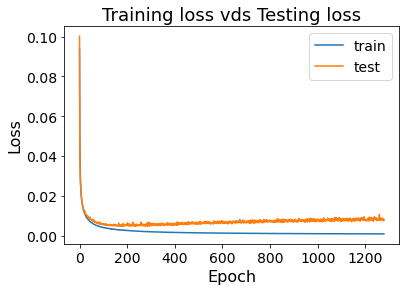

In [35]:
lr = 0.00001
EPOCHS = 6000


lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


model.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
                optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/cnn_encoder_decoder_24h_energy.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model.fit(x=[train_X, train_future_cov], y=train_y, 
                    epochs=EPOCHS,
                    verbose=2,
                    validation_data=([test_X, test_future_cov], test_y),
                    batch_size = 512,
                    callbacks=[es, mc]
                   )

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vds Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Prediction

In [79]:
from tensorflow.keras.models import load_model

model = load_model('saved_model/cnn_encoder_decoder_24h_energy.h5')

In [80]:
y_hat = model.predict([test_X, test_future_cov])

In [81]:
print(y_hat.shape)
print(test_y.shape)

(6918, 24)
(6918, 24)


In [82]:
# print(y_hat.shape)
# y_hat = y_hat.reshape((-1, y_hat.shape[1]*y_hat.shape[2]))
# print(y_hat.shape)

In [83]:
# print(test_y.shape)
# test_y = test_y.reshape((-1, test_y.shape[1]*test_y.shape[2]))
# # print(test_y.shape)

In [84]:
inv_yhat = scaler.inverse_transform(y_hat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (6918, 24) (6918, 24)


### Performance

In [85]:
# K=24h
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 3.785
RMSE = 5.089
